In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [114]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.

import tensorflow
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)
    #set_random_seed(0)
seed_everything()

import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from PIL import Image
import seaborn as sns


%matplotlib inline
#sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [117]:
IMG_SIZE = 224
RANDOM_STATE = 974
VERBOSE = True

warnings.filterwarnings('ignore')

DATA_AUGM = True
DATA_AUGM_FACTOR = 1

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from random import randrange

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.



['aptos2019-blindness-detection']


In [25]:
# load csv files with labels as pandas dataframes
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [26]:
# find out the number of images in test ans train sets
print('Number of images in training set is {}'.format(len(train)))
print('Number of images in test set is {}'.format(len(test)))

Number of images in training set is 3662
Number of images in test set is 1928


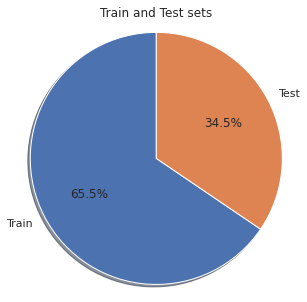

In [27]:
# Plot pie chart
labels = 'Train', 'Test'
sizes = len(train), len(test)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Train and Test sets')
plt.show()

In [28]:
sample_submission = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/sample_submission.csv")
print(sample_submission.head())
test_file = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
df_train = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
print(test_file.head())
print(df_train.head())

        id_code  diagnosis
0  0005cfc8afb6          0
1  003f0afdcd15          0
2  006efc72b638          0
3  00836aaacf06          0
4  009245722fa4          0
        id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


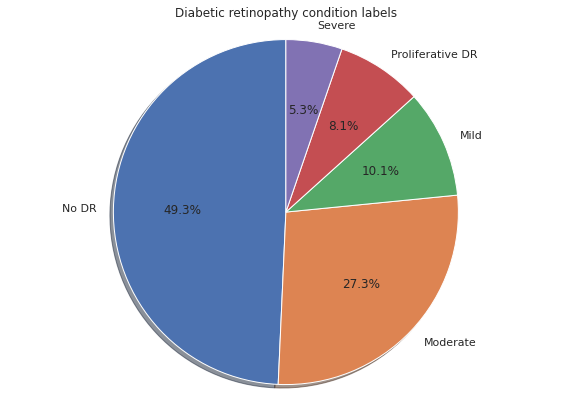

In [29]:
# Plot pie chart
labels = 'No DR', 'Moderate', 'Mild', 'Proliferative DR', 'Severe'
sizes = df_train.diagnosis.value_counts()

fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Diabetic retinopathy condition labels')
plt.show()

# Imbalanced dataset

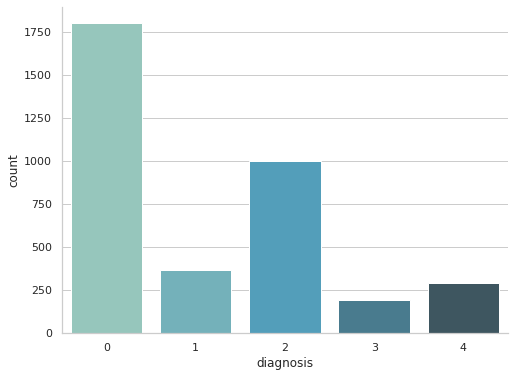

In [30]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="diagnosis", data=df_train, palette="GnBu_d")
sns.despine()
plt.show()
#highly imbalanced dataset

# Visualize Sample Images

In [31]:
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
SEED = 77
random.seed(SEED)
IMG_CHANNELS = 3
IMG_WIDTH = 512

# These are used for histogram equalization
clipLimit=2.0 
tileGridSize=(8, 8)  

channels = {"R":0, "G": 1, "B":2}

In [32]:
def draw_img(imgs, class_label='0'):
    fig, axis = plt.subplots(2, 2, figsize=(8, 6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = (f'../input/aptos2019-blindness-detection/train_images/{row["id_code"]}.png')
        img = cv2.imread(imgPath)
        row = idnx // 2
        col = idnx % 2
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis[row, col].imshow(img)
    plt.suptitle(class_label)
    plt.show()

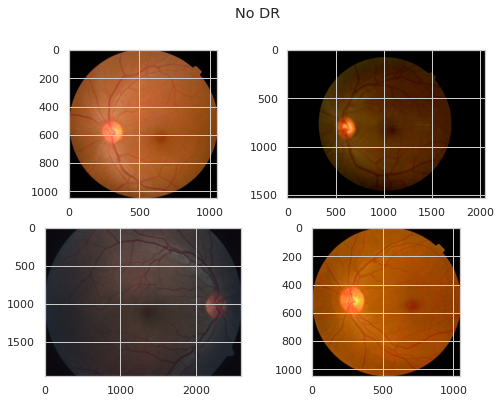

In [33]:
CLASS_ID = 0
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(4), CLASSS[CLASS_ID])

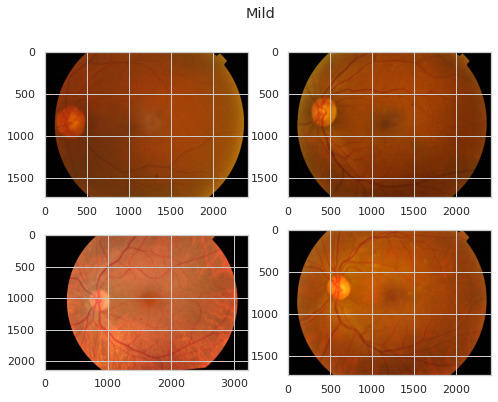

In [34]:
CLASS_ID = 1
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(4), CLASSS[CLASS_ID])

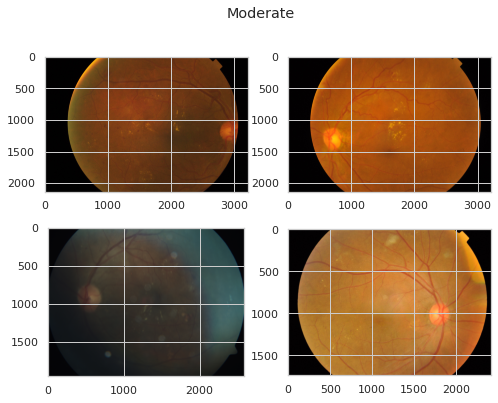

In [35]:
CLASS_ID = 2
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(4), CLASSS[CLASS_ID])

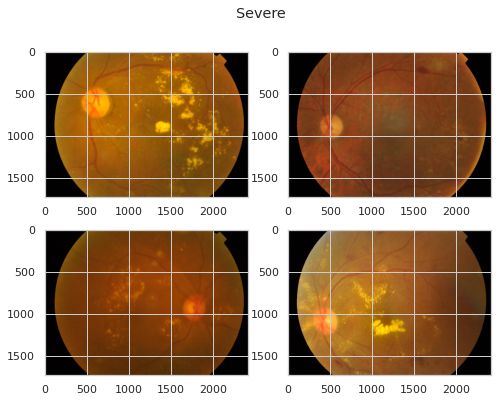

In [36]:
CLASS_ID = 3
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(4), CLASSS[CLASS_ID])

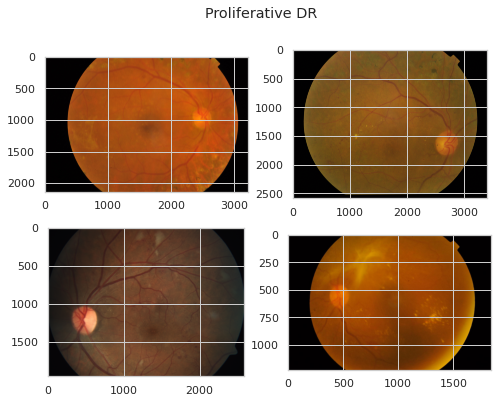

In [37]:
CLASS_ID = 4
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(4), CLASSS[CLASS_ID])

# Analyze image size

In [38]:
TRAIN_IMG_PATH = "../input/aptos2019-blindness-detection/train_images/"
TEST_IMG_PATH = "../input/aptos2019-blindness-detection/test_images/"
def get_image_sizes(df, train = True):
    '''
    Function to get sizes of images from test and train sets.
    INPUT:
        df - dataframe containing image filenames
        train - indicates whether we are getting sizes of images from train or test set
    '''
    if train:
        path = TRAIN_IMG_PATH
    else:
        path = TEST_IMG_PATH
        
    widths = []
    heights = []
    
    images = df.id_code
    
    max_im = Image.open(os.path.join(path, images[0] + '.png'))
    min_im = Image.open(os.path.join(path, images[0] + '.png'))
        
    for im in range(0, len(images)):
        image = Image.open(os.path.join(path, images[im] + '.png'))
        width, height = image.size
        
        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)
        
    return widths, heights, max_im, min_im

In [39]:
# get sizes of images from test and train sets
train_widths, train_heights, max_train, min_train = get_image_sizes(train, train = True)
test_widths, test_heights, max_test, min_test = get_image_sizes(test, train = False)

In [40]:
print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

Maximum width for training set is 4288
Minimum width for training set is 474
Maximum height for training set is 2848
Minimum height for training set is 358


In [41]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

Maximum width for test set is 2896
Minimum width for test set is 640
Maximum height for test set is 1958
Minimum height for test set is 480


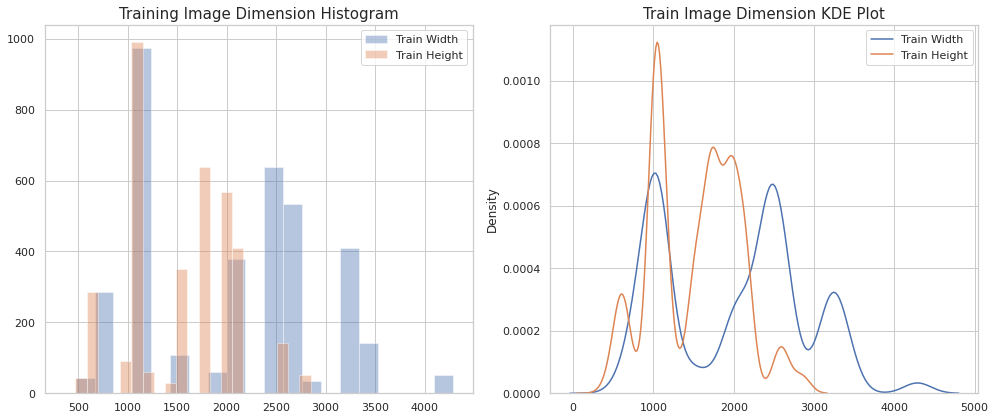

In [42]:
# Plot Histograms and KDE plots for images from the training set
# Source: https://www.kaggle.com/chewzy/eda-weird-images-with-new-updates
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot(train_widths, kde=False, label='Train Width')
sns.distplot(train_heights, kde=False, label='Train Height')
plt.legend()
plt.title('Training Image Dimension Histogram', fontsize=15)

plt.subplot(122)
sns.kdeplot(train_widths, label='Train Width')
sns.kdeplot(train_heights, label='Train Height')
plt.legend()
plt.title('Train Image Dimension KDE Plot', fontsize=15)

plt.tight_layout()
plt.show()

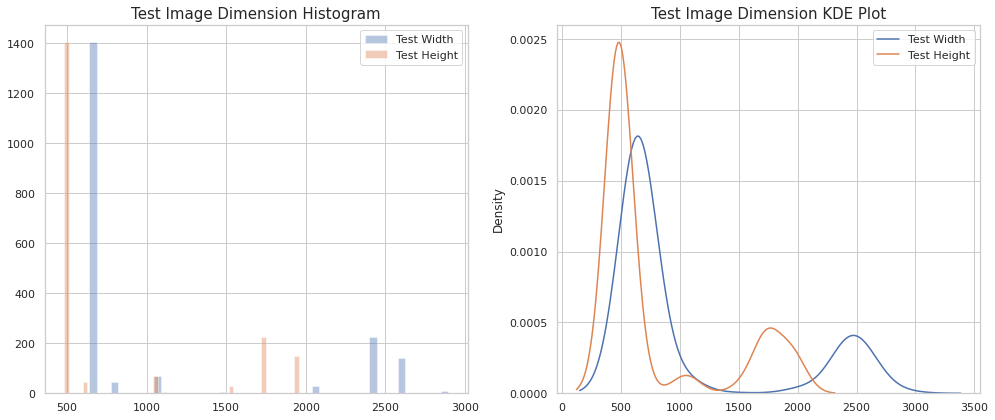

In [43]:
# Plot Histograms and KDE plots for images from the test set
# Source: https://www.kaggle.com/chewzy/eda-weird-images-with-new-updates
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot(test_widths, kde=False, label='Test Width')
sns.distplot(test_heights, kde=False, label='Test Height')
plt.legend()
plt.title('Test Image Dimension Histogram', fontsize=15)

plt.subplot(122)
sns.kdeplot(test_widths, label='Test Width')
sns.kdeplot(test_heights, label='Test Height')
plt.legend()
plt.title('Test Image Dimension KDE Plot', fontsize=15)

plt.tight_layout()
plt.show()

# Split dataset into training, validation, and testing

In [45]:
from sklearn.model_selection import train_test_split
df_train, valid_df = train_test_split(df_train, test_size=0.20, random_state=974)
df_train, test_df = train_test_split(df_train, test_size=0.15, random_state=974)

In [47]:
print(df_train.shape,valid_df.shape,test_df.shape)

(2489, 2) (733, 2) (440, 2)


In [48]:
test_df.head()

,id_code,diagnosis
1865,83b61051737f,2
3026,d26bb2ed6e71,0
2726,bcc762618e7d,2
2280,a06e41bd2634,2
910,4205e9deb058,0


In [49]:
valid_df.head()

,id_code,diagnosis
1309,5b2648ad455e,0
1992,8be6629a6039,0
2218,9bbb6c455913,0
647,2da82d14e1b7,0
2128,95e732e043a1,4


In [50]:
df_train['diagnosis'].value_counts()

0    1229
2     670
1     265
4     193
3     132
Name: diagnosis, dtype: int64

In [62]:
#Create an id column after random splitting
rows = []
for i in range(len(df_train)):
    rows.append(i)
    i+=1

In [63]:
idd = pd.Series(rows)
df_train['idd'] = idd.values

In [64]:
df_train.set_index('idd', inplace=True)

Training, Validation, and Testin sets, are saved into another dataset folder to be used later in diffrent experiments 

# Image preprocessing 

In [60]:
#display images from training dataset
def display_samples(df, columns=5, rows=4):
    fig=plt.figure(figsize=(3*columns, 2*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()
#disply sample of the images titled with the labe case

In [52]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
           # print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [53]:
def load_ben_color(image, sigmaX=30):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [73]:
def image_preprocessing(path, sigmaX=25):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = load_ben_color(image,sigmaX)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    #image= cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
        
    return image

In [149]:
def openImage(row, train=True, resize=False):
    image = None
    if not train:
        image = cv2.imread('./preprocessing/class_'+str(row.diagnosis)+'/'+row.id_code)
    elif not pd.isnull(row.id_code):
        image = cv2.imread('./preprocessing/class_'+str(row.diagnosis)+'/'+row.id_code)
    
    else:
        print("[Error] Could not open the image. Log: {}".format(row))
    if resize and not image is None:
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

In [101]:
#display images from training dataset
def display_samples2(df, columns=5, rows=4):
    fig=plt.figure(figsize=(3*columns, 2*rows))
    j = 0

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread('./preprocessing/class_'+df_train.diagnosis[j]+'/'+df_train.id_code[j]+'.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
        j+=1
    
    plt.tight_layout()

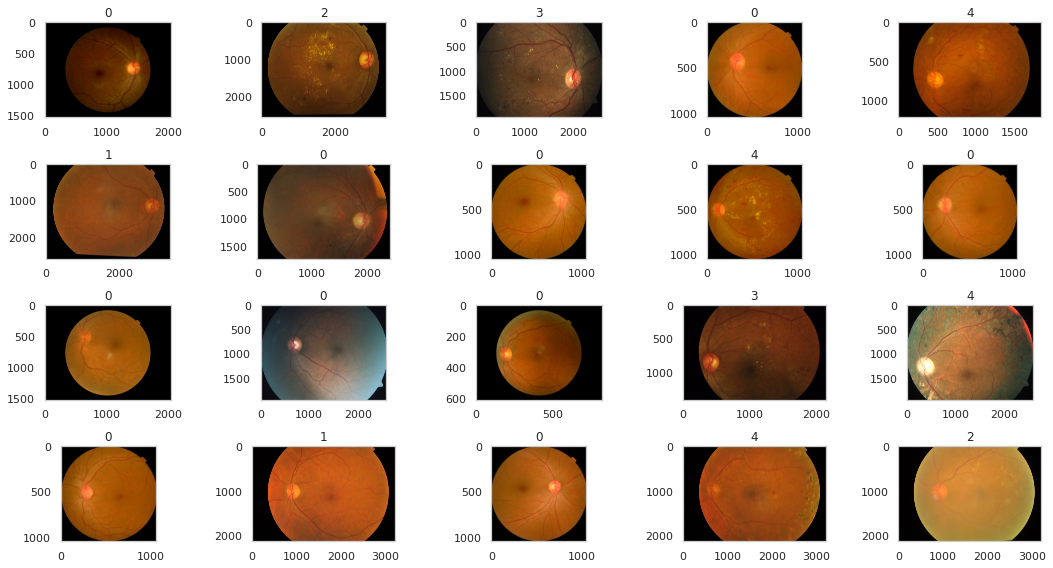

In [108]:
display_samples(df_train)

In [67]:
#Create a directory
PATH_PROCESSING = './preprocessing/'

In [68]:
#Make directories based on the classes to classify images #once
#The images after preprocessing will be saved here
os.makedirs(PATH_PROCESSING+'class_1')
os.makedirs(PATH_PROCESSING+'class_2')
os.makedirs(PATH_PROCESSING+'class_3')
os.makedirs(PATH_PROCESSING+'class_4')
os.makedirs(PATH_PROCESSING+'class_0')

In [132]:
df_train['diagnosis'] = df_train['diagnosis'].astype(str)
df_train['id_code'] = df_train['id_code'].astype(str)

In [78]:
#Make a copy of the preprocessed images from the augmented dataset and classify them based on the class number #once

j = 0
for i in range(len(df_train)):
    
    if df_train.diagnosis[j] == '0':
        image = '../input/aptos2019-blindness-detection/train_images/'+df_train.id_code[j]+'.png'
        image = cv2.cvtColor(image_preprocessing(image,10), cv2.COLOR_BGR2RGB) 
        #data_generator.fit(image)
        image = Image.fromarray(image)
        image = image.save('./preprocessing/class_0/'+df_train.id_code[j]+'.png')
        
        j+=1
    elif df_train.diagnosis[j] == '1':
        
        image = '../input/aptos2019-blindness-detection/train_images/'+df_train.id_code[j]+'.png'
        image = cv2.cvtColor(image_preprocessing(image,10), cv2.COLOR_BGR2RGB) 
        #data_generator.fit(image)
        image = Image.fromarray(image)
        image = image.save('./preprocessing/class_1/'+df_train.id_code[j]+'.png')
        j+=1
        
    elif df_train.diagnosis[j] == '2':
        image = '../input/aptos2019-blindness-detection/train_images/'+df_train.id_code[j]+'.png'
        image = cv2.cvtColor(image_preprocessing(image,10), cv2.COLOR_BGR2RGB) 
        #data_generator.fit(image)
        image = Image.fromarray(image)
        image = image.save('./preprocessing/class_2/'+df_train.id_code[j]+'.png')
        j+=1
        
    elif df_train.diagnosis[j] == '3':
        image = '../input/aptos2019-blindness-detection/train_images/'+df_train.id_code[j]+'.png'
        image = cv2.cvtColor(image_preprocessing(image,10), cv2.COLOR_BGR2RGB) 
        #data_generator.fit(image)
        image = Image.fromarray(image)
        image = image.save('./preprocessing/class_3/'+df_train.id_code[j]+'.png')
        j+=1
        
    elif df_train.diagnosis[j] == '4':
        image = '../input/aptos2019-blindness-detection/train_images/'+df_train.id_code[j]+'.png'
        image = cv2.cvtColor(image_preprocessing(image,10), cv2.COLOR_BGR2RGB) 
        #data_generator.fit(image)
        image = Image.fromarray(image)
        image = image.save('./preprocessing/class_4/'+df_train.id_code[j]+'.png')
        j+=1
    i+=1
print(j)

2489


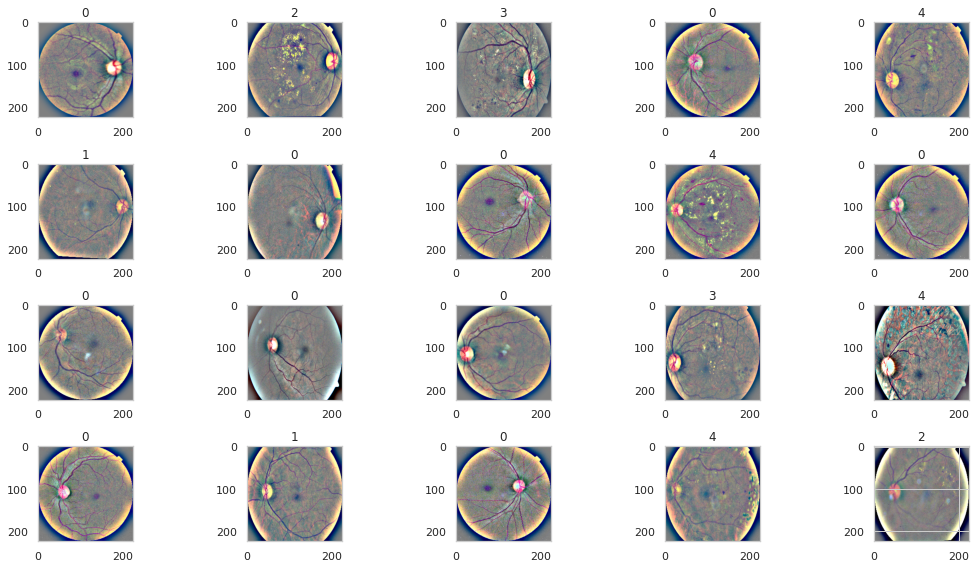

In [107]:
display_samples2(df_train)

# Image Augmentation for data balancing
- rotation by 360
- random vertically flip 
- random horizontally flip 
- zoom_range=0.1

In [135]:
df_train.id_code = df_train.id_code+'.png'

In [144]:
#create a new column for image augmentation and fill it with null
df_train["data_augm"] = np.nan
if VERBOSE:
    display(df_train.head())
    print(df_train.shape)

,id_code,diagnosis,data_augm
idd,,,
673,c7b622ec8104.png,1,NaN
478,67ed8cc78b97.png,0,NaN
74,58059e73d2d4.png,0,NaN
2414,35aa7f5c2ec0.png,1,NaN
703,68332fdcaa70.png,1,NaN


(2489, 3)


In [150]:
PATH_AUGM = './/data_augm/'
if DATA_AUGM:
    shutil.rmtree(PATH_AUGM, ignore_errors=True, onerror=None)
    shutil.os.mkdir(PATH_AUGM)
    df_train = shuffle(df_train, random_state=RANDOM_STATE)
    max_size = int(df_train.diagnosis.value_counts().max() * DATA_AUGM_FACTOR)
    df_train['diagnosis'] = df_train['diagnosis'].astype(int)
    
    for diag in range(5):
        shutil.rmtree('{}diag_{}'.format(PATH_AUGM, diag), ignore_errors=True, onerror=None)
        shutil.os.mkdir('{}diag_{}'.format(PATH_AUGM, diag))
        diag_df = df_train[df_train.diagnosis == diag]
        #to avoid devision by zero
        size = len(diag_df)
        
        if (size == 0):
            print('redefine the id')

        to_create = max_size - (size)
        
        augm_per_img = max(to_create // size, 1)
        
        while to_create > 0:
            
            for row in diag_df.itertuples():
                
                if to_create < 0:
                    
                    break
                
                image = np.expand_dims(cv2.cvtColor(openImage(row, resize=True), cv2.COLOR_BGR2RGB), 0)
            
                data_generator = ImageDataGenerator(rotation_range=360,vertical_flip=True,horizontal_flip=True, zoom_range=0.1)
                
                data_generator.fit(image)
                
                id_code = row.id_code if not pd.isnull(row.id_code) else row.id_code
                
                for x, val in zip(data_generator.flow(image, save_to_dir='{}diag_{}'.format(PATH_AUGM, diag),save_prefix=id_code, save_format='png'), range(augm_per_img - 1)):
                    pass
                
                to_create -= augm_per_img
    for diag in range(5):
        images = np.array(os.listdir("{}diag_{}".format(PATH_AUGM, diag)))
        for image in images:
            df_train = df_train.append(pd.DataFrame([[np.nan,diag , "{}diag_{}/{}".format(PATH_AUGM, diag, image)]], columns=df_train.columns))
    df_train = shuffle(df_train, random_state=RANDOM_STATE)
    display(df_train.head())


,id_code,diagnosis,data_augm
800,8a01daa423f7.png,1,NaN
0,NaN,3,.//data_augm/diag_3/b2ffa3e18559.png_0_2893.png
0,NaN,2,.//data_augm/diag_2/e6f0ce5bf282.png_0_2196.png
0,NaN,3,.//data_augm/diag_3/4b618537d52f.png_0_9542.png
0,NaN,2,.//data_augm/diag_2/203275daf46d.png_0_4430.png


In [151]:
df_train.shape

(6158, 3)

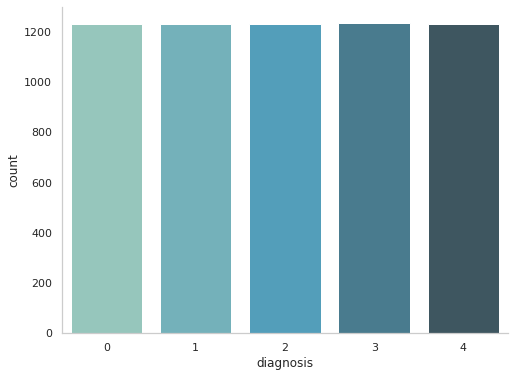

In [152]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="diagnosis", data=df_train, palette="GnBu_d")
sns.despine()
plt.show()
#highly imbalanced dataset

In [156]:
df_train.to_csv('balanced_aug_dataset',index=False)